In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'classification'

def save_fig(fig_id, tight_layout=True):
    path = os.path.join('./images', fig_id + '.png')
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## MNIST

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8)
    sort_by_target(mnist)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist['data'], mnist['target']
    

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
28*28

784

Saving figure some_digit_plot


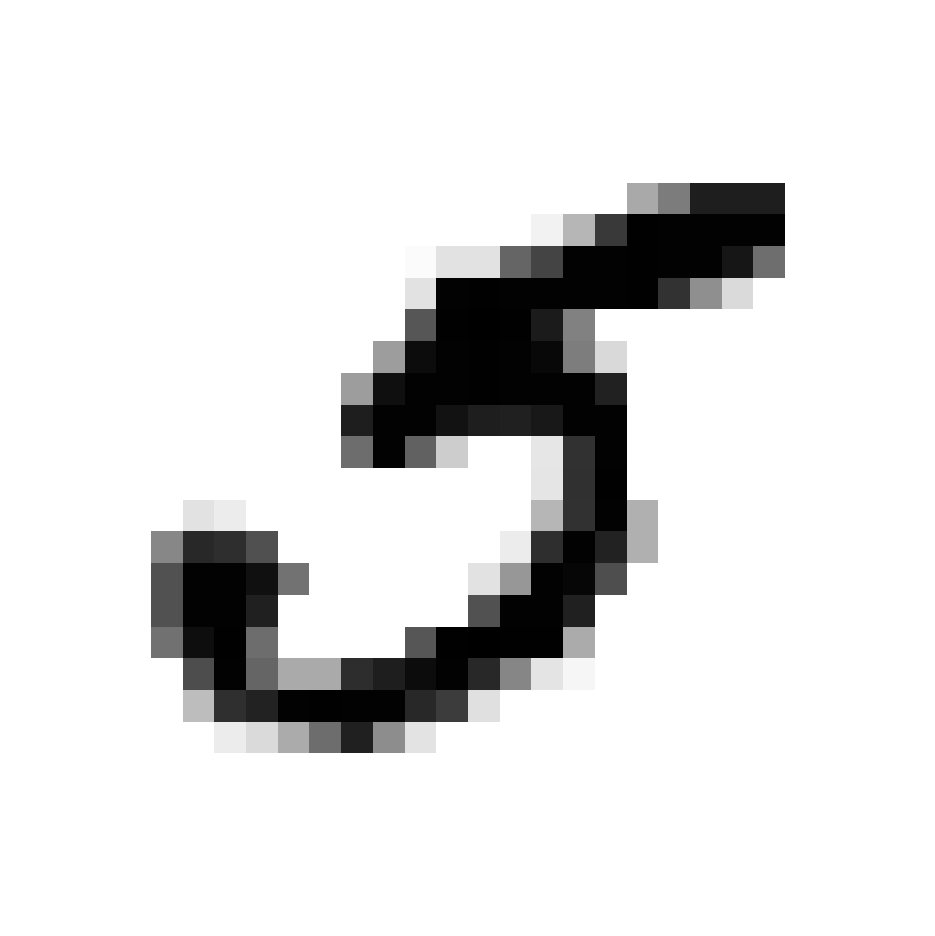

In [8]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
          interpolation='nearest')
plt.axis('off')

save_fig('some_digit_plot')
plt.show()

In [9]:
y[36000]

5

In [10]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:], y[:60000], y[60000:]

In [11]:
# some learning algorithms are sensitive to the order of the training instances, and they perform
# poorly if they get many similar instances in a row. Shuffling the dataset ensures that
# this won’t happen

# Shuffling may be a bad idea in some contexts—for example, if you are working on time series data (such as
# stock market prices or weather conditions)

In [12]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#### Training a Binary Classifier

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

**Measuring Accuracy Using Cross-Validation**

**Implementing Cross-Validation**

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9613, 0.9635, 0.9661])

**Cross-validation pure implemantation**

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9613
0.9635
0.9661


In [17]:
# The StratifiedKFold class performs stratified sampling 
# to produce folds that contain a representative ratio of each class. At each iteration the
# code creates a clone of the classifier, trains that clone on the training folds, and makes
# predictions on the test fold. Then it counts the number of correct predictions and
# outputs the ratio of correct predictions.

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [ ]:
# That’s right, it has over 90% accuracy! This is simply because only about 10% of the
# images are 5's, so if you always guess that an image is not a 5, you will be right about
# 90% of the time.

# This demonstrates why accuracy is generally not the preferred performance measure
# for classifiers, especially when you are dealing with skewed datasets (i.e., when some
# classes are much more frequent than others).

### Confusion Matrix

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
# Just like the cross_val_score() function, cross_val_predict() performs K-fold
# cross-validation, but instead of returning the evaluation scores, it returns the predic‐
# tions made on each test fold
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]], dtype=int64)

**The perfect precision Matrix**

In [24]:
# No false positives or No false negatives;
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

**Precision and Recall**

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8899590657356128

In [26]:
recall_score(y_train_5, y_train_pred)

0.6817930271167681

In [ ]:
# It is often convenient to combine precision and recall into a single metric called the F1
# score, in particular if you need a simple way to compare two classifiers. The F1
#  score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean
# treats all values equally, the harmonic mean gives much more weight to low values.
# As a result, the classifier will only get a high F1  score if both recall and precision are high.

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7720910800083559

In [ ]:
# The F1 score favors classifiers that have similar precision and recall. This is not always
# what you want: in some contexts you mostly care about precision, and in other con‐
# texts you really care about recall. For example, if you trained a classifier to detect vid‐
# eos that are safe for kids, you would probably prefer a classifier that rejects many
# good videos (low recall) but keeps only safe ones (high precision), rather than a clas‐
# sifier that has a much higher recall but lets a few really bad videos show up in your
# product (in such cases, you may even want to add a human pipeline to check the clas‐
# sifier’s video selection). On the other hand, suppose you train a classifier to detect
# shoplifters on surveillance images: it is probably fine if your classifier has only 30%
# precision as long as it has 99% recall (sure, the security guards will get a few false
# alerts, but almost all shoplifters will get caught).

**Decision threshold and precision/recall tradeo**

In [92]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5220.50278623])

In [93]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [94]:
# raising the threshold decreases recall. The image actually repre‐
# sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
# threshold is increased to 200,000.

In [95]:

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [96]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([ -20459.8132648 , -128135.95428981,  -39453.27540023, ...,
        -45296.1297672 ,  -29061.21602769,  -13530.44145905])

In [97]:
y_scores.shape

(60000,)

In [98]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [101]:

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

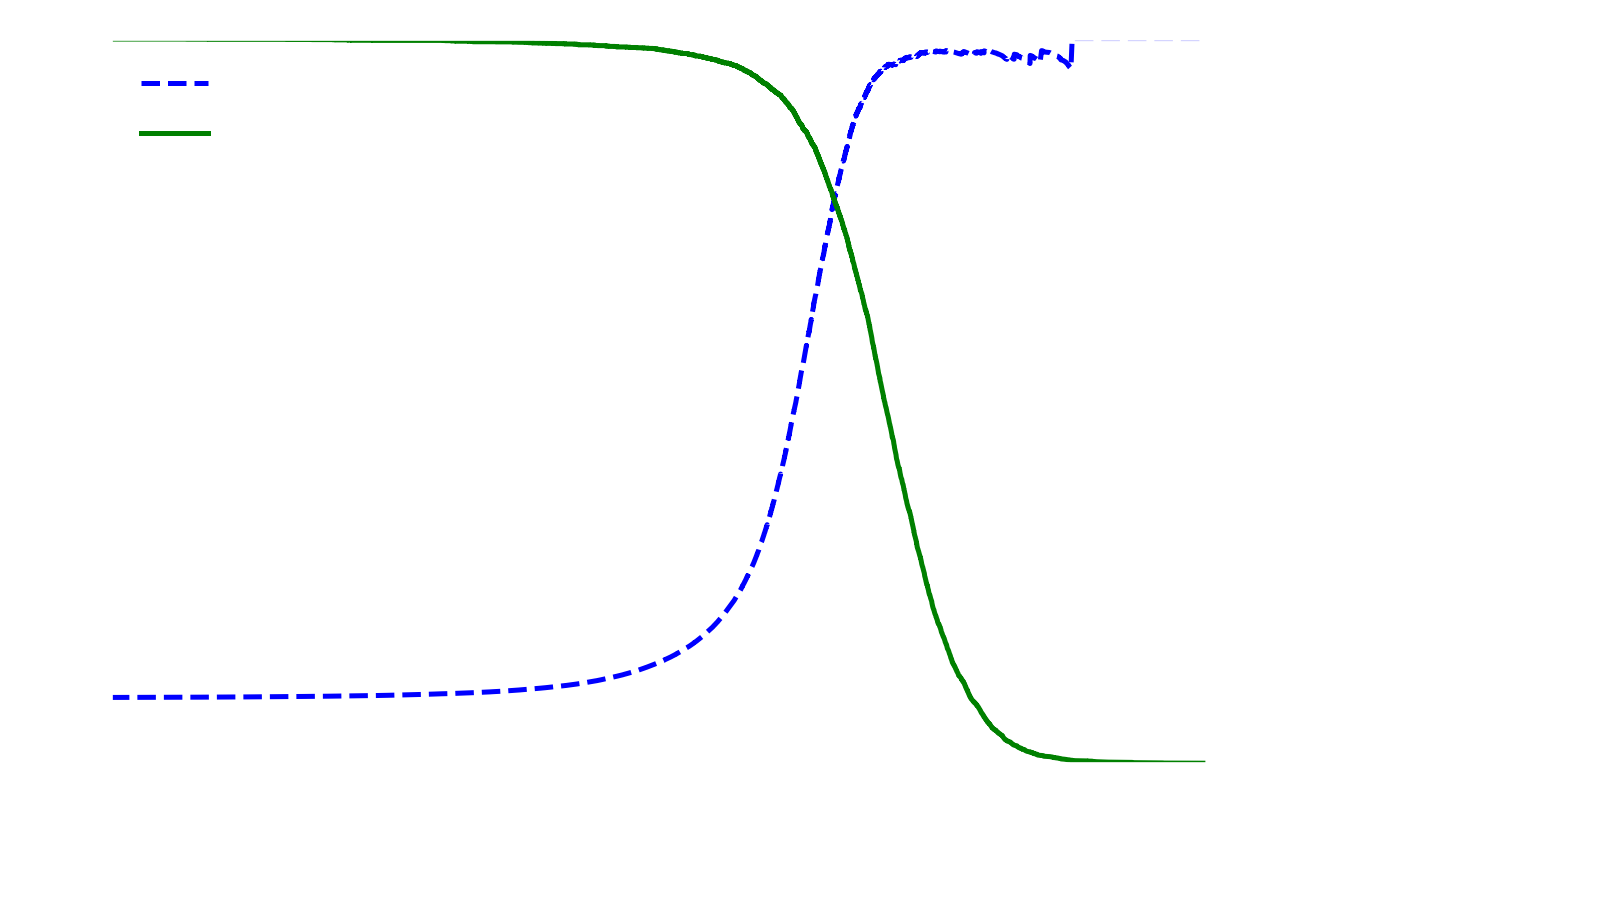

In [105]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")
    plt.xlabel('Threshold')
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-70000, 70000])
plt.show();

Saving figure precision_vs_recall_plot


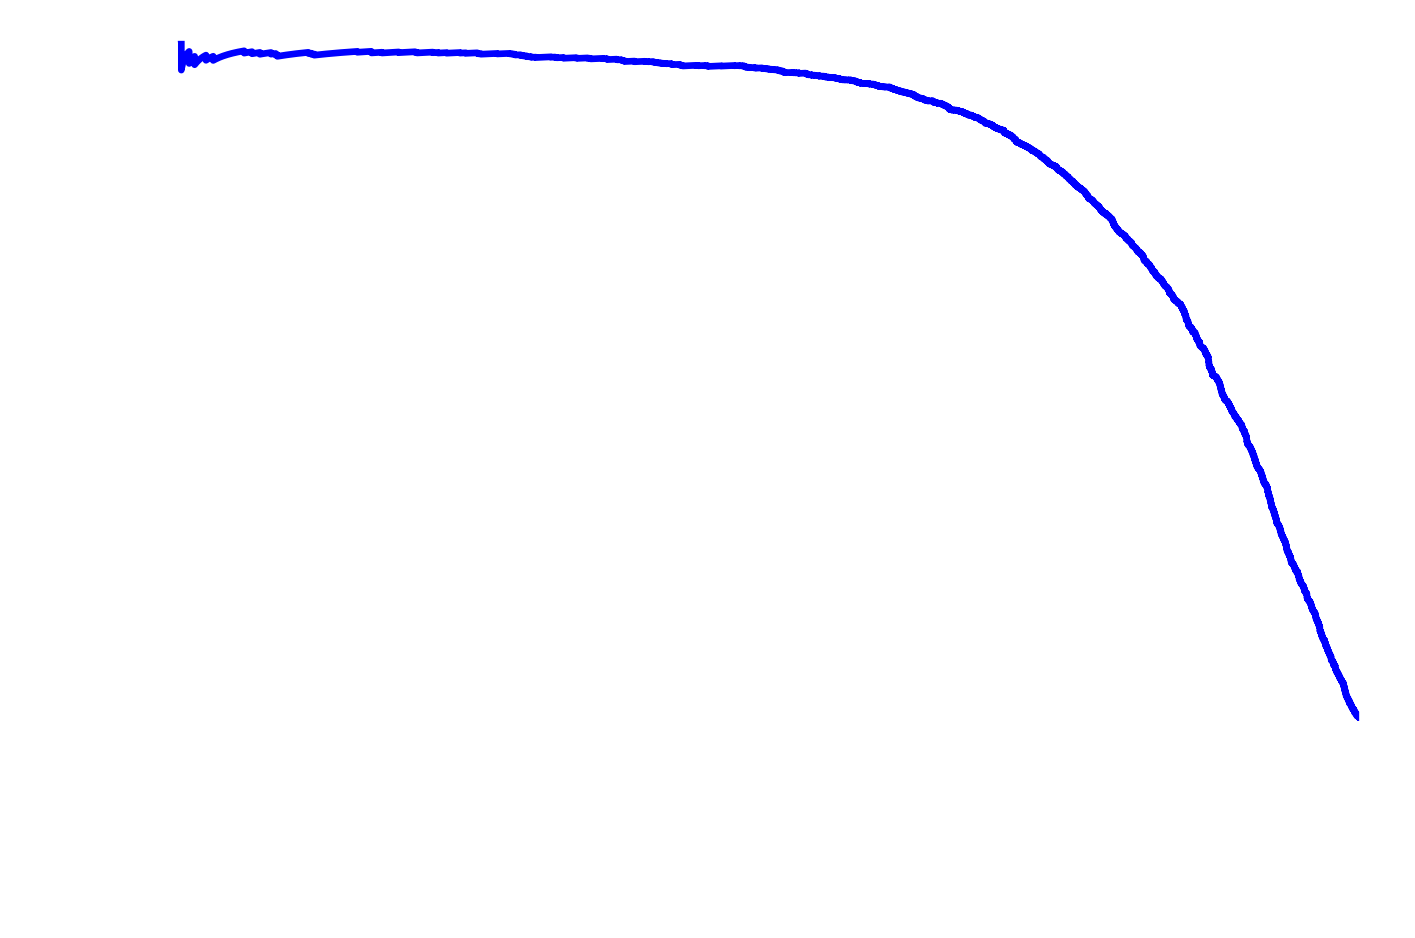

In [106]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0,1,0,1])

plt.figure(figsize=(6,4))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [ ]:
# You can see that precision really starts to fall sharply around 80% recall. You will
# probably want to select a precision/recall tradeoff just before that drop—for example,
# at around 60% recall.

**suppose you decide to aim for 90% precision**

In [107]:
y_train_pred_90 = (y_scores > 20000)
precision_score(y_train_5, y_train_pred_90)


0.9642857142857143

In [108]:
recall_score(y_train_5, y_train_pred_90)

0.004980630879911455

**The ROC curve**

In [109]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

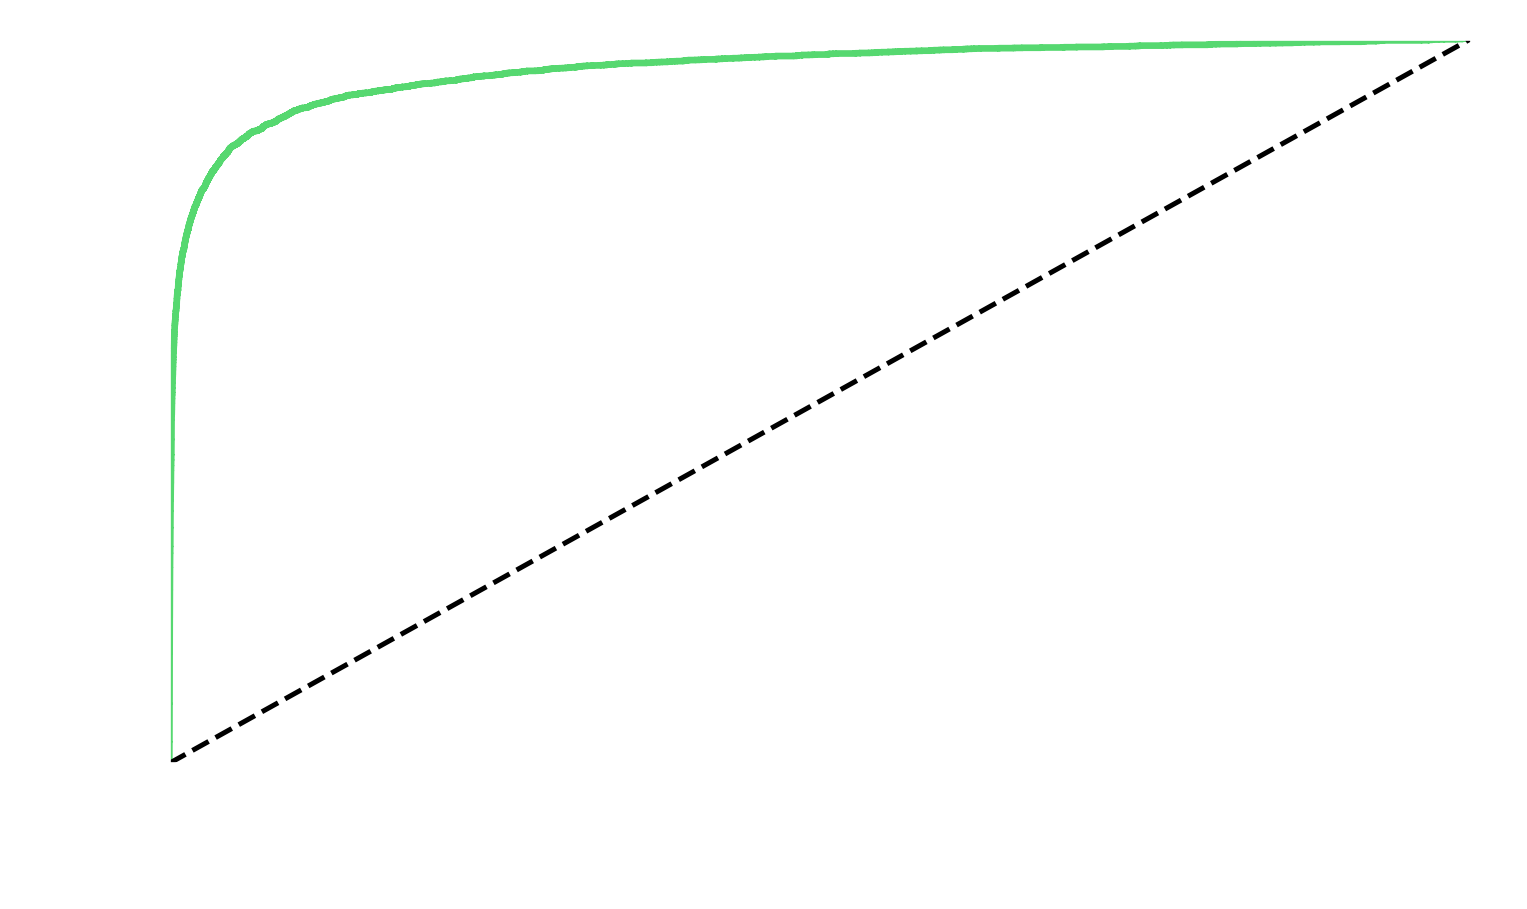

In [111]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [112]:
# Area under the curve
# One way to compare classifiers is to measure the area under the curve (AUC). A per‐
# fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
# have a ROC AUC equal to 0.5.

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)


0.9577210519742373

**RandomForestClassifier --- predict_proba** 

In [113]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [118]:
y_scores_forest = y_probas_forest[:, 1] # proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


array([0.  , 0.02, 0.  , ..., 0.01, 0.02, 0.  ])

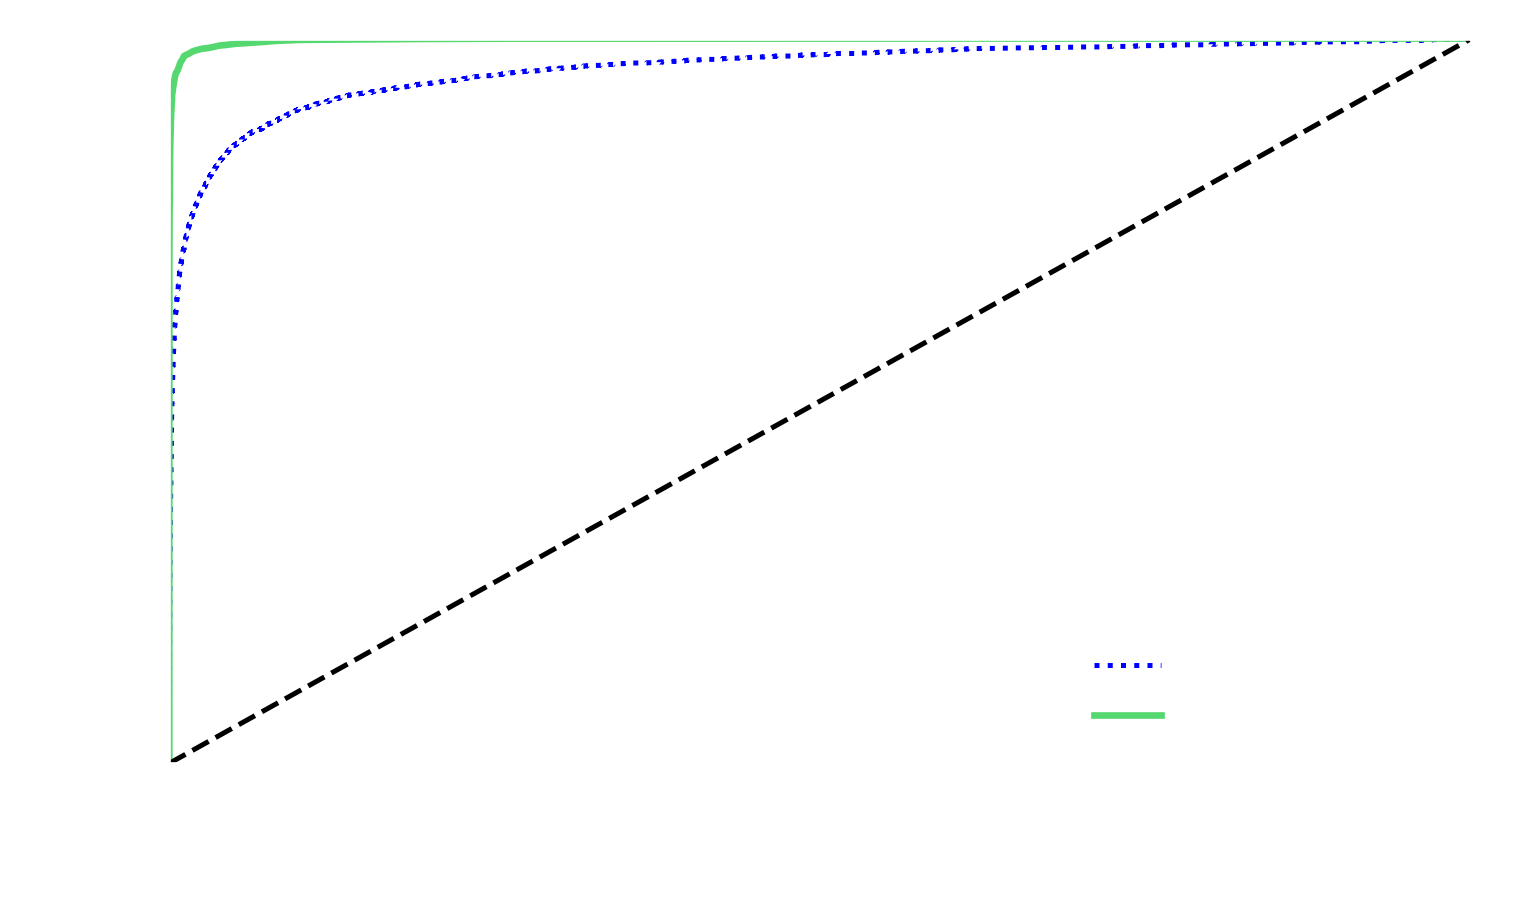

In [122]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right");
plt.show();


In [130]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983730844244434

**RandomForestClassifier --- normal -- High recall and High precision**

In [133]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [135]:
recall_score(y_train_5, y_train_pred_forest)


0.8690278546393654

In [136]:
precision_score(y_train_5, y_train_pred_forest)

0.9888748950461796

In [134]:
# Hopefully you now know how to train binary classifiers, choose the appropriate met‐
# ric for your task, evaluate your classifiers using cross-validation, select the precision/
# recall tradeoff that fits your needs, and compare various models using ROC curves
# and ROC AUC scores. 


**Multiclass Classification**

In [ ]:
# Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are
# capable of handling multiple classes directly. Others (such as Support Vector Machine
# classifiers or Linear classifiers) are strictly binary classifiers. However, there are vari‐
# ous strategies that you can use to perform multiclass classification using multiple
# binary classifiers.

In [137]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [138]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -8204.47519778, -19206.28224706,  -5702.10113982,
         -4666.3653033 , -15827.7809826 ,   1782.52380291,
        -39807.3747045 , -18945.8333413 , -14650.34384565,
        -16166.06981109]])

In [139]:
np.argmax(some_digit_scores)

5

In [140]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [141]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([5], dtype=int8)

In [142]:
len(ovo_clf.estimators_)

45

In [143]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [144]:
# This time Scikit-Learn did not have to run OvA or OvO because Random Forest
# classifiers can directly classify instances into multiple classes. You can call
# predict_proba() to get the list of probabilities that the classifier assigned to each
# instance for each class:
forest_clf.predict_proba([some_digit])

array([[0.06, 0.  , 0.01, 0.07, 0.  , 0.86, 0.  , 0.  , 0.  , 0.  ]])

In [145]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.88875, 0.8722 , 0.87905])

### Errors analysis

In [157]:
from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
sgd_clf_2 = SGDClassifier(random_state=42, max_iter=5)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.9091 , 0.90955, 0.9062 ])

In [158]:
# from  warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning
# simplefilter("ignore", category=ConvergenceWarning)

y_train_pred = cross_val_predict(sgd_clf_2, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5728,    3,   18,   10,   11,   48,   54,   10,   38,    3],
       [   2, 6472,   43,   27,    6,   41,    6,    9,  124,   12],
       [  59,   39, 5300,  103,   96,   24,   99,   57,  167,   14],
       [  60,   42,  133, 5357,    4,  213,   35,   52,  135,  100],
       [  14,   28,   33,    9, 5366,    8,   56,   33,   88,  207],
       [  68,   49,   30,  197,   76, 4566,  118,   33,  190,   94],
       [  35,   28,   31,    1,   47,   86, 5639,    9,   42,    0],
       [  22,   20,   70,   29,   65,   11,    6, 5789,   18,  235],
       [  55,  158,   63,  157,   11,  155,   61,   24, 5022,  145],
       [  38,   37,   30,   85,  185,   24,    2,  216,   74, 5258]],
      dtype=int64)

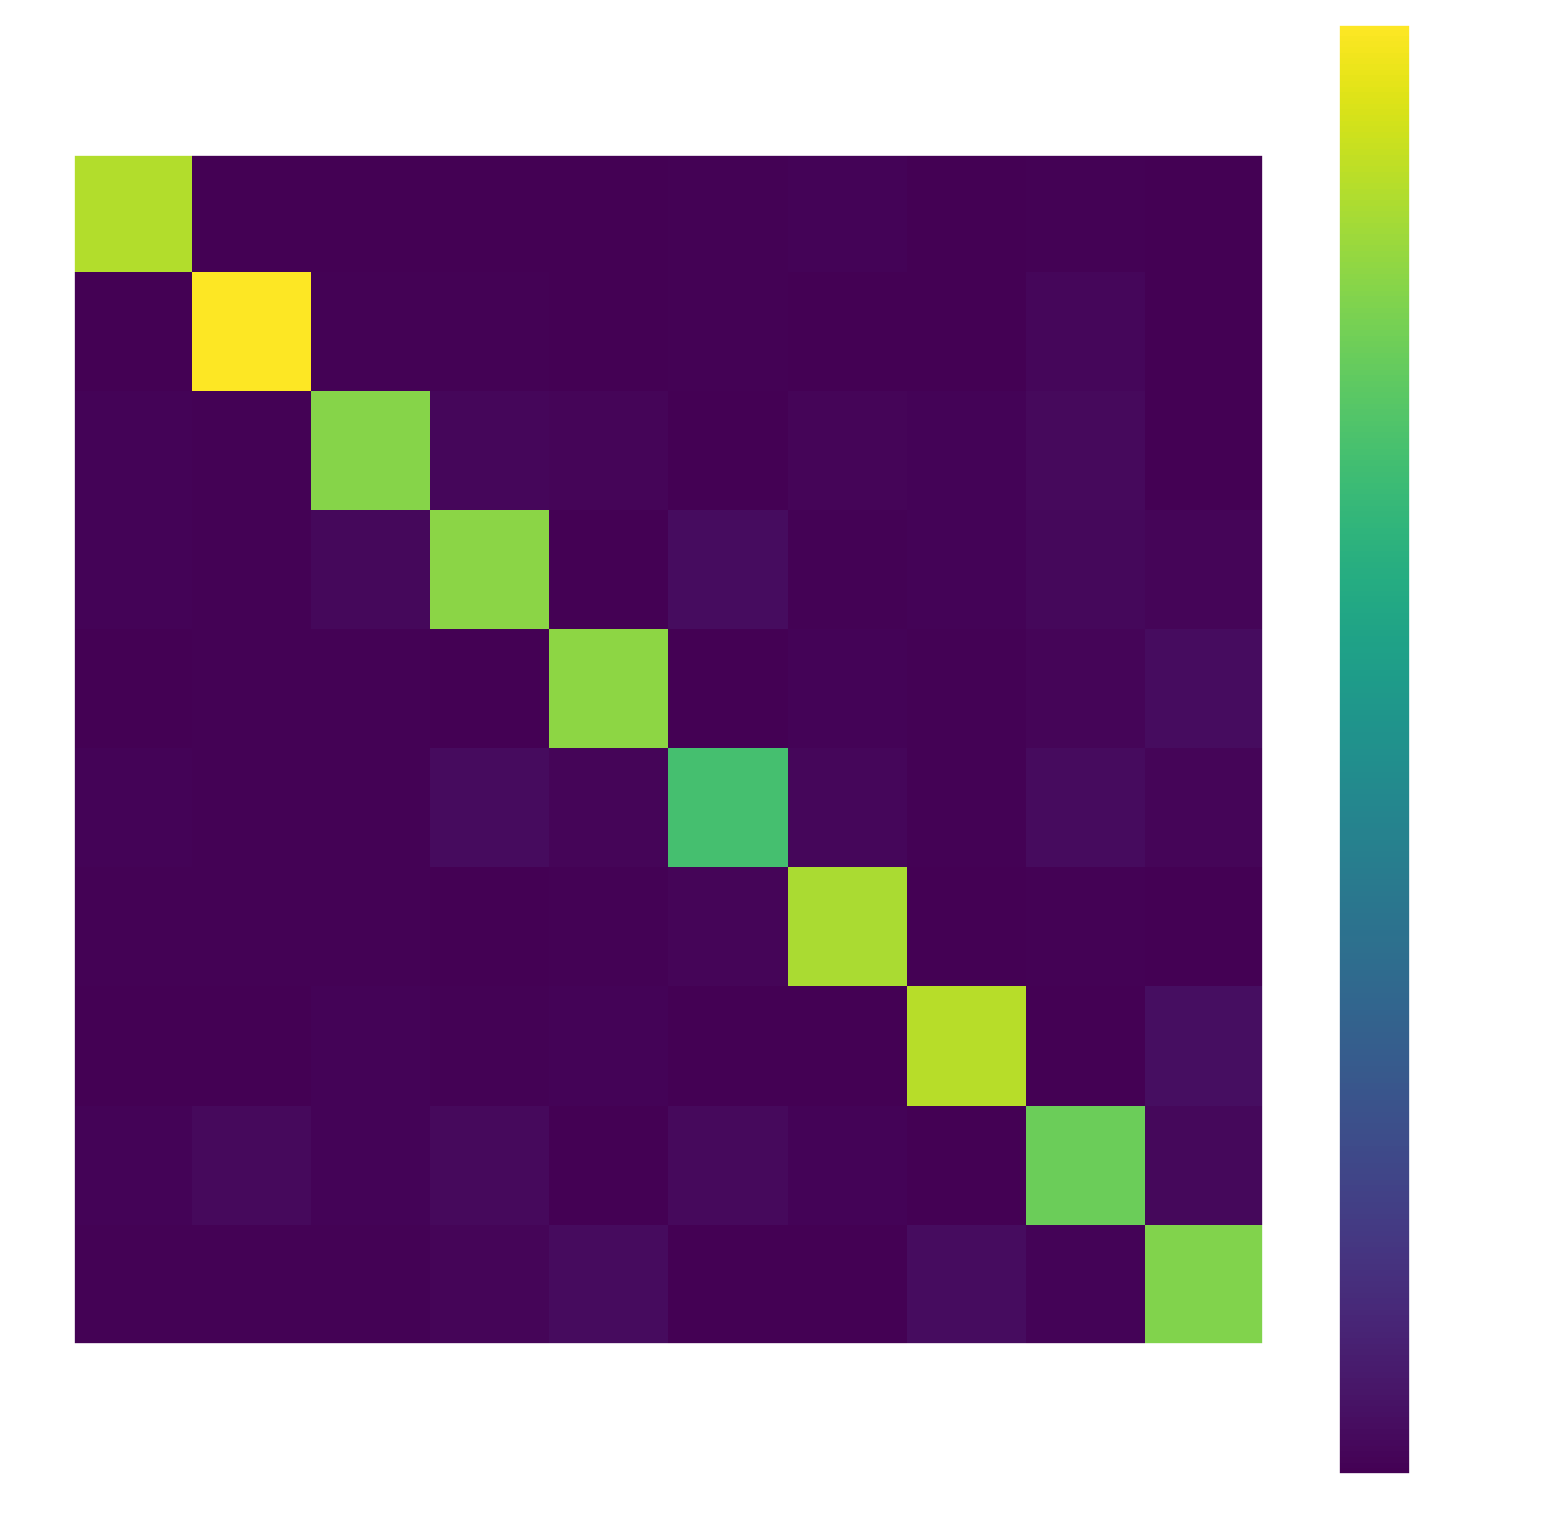

In [160]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plot_confusion_matrix(conf_mx)

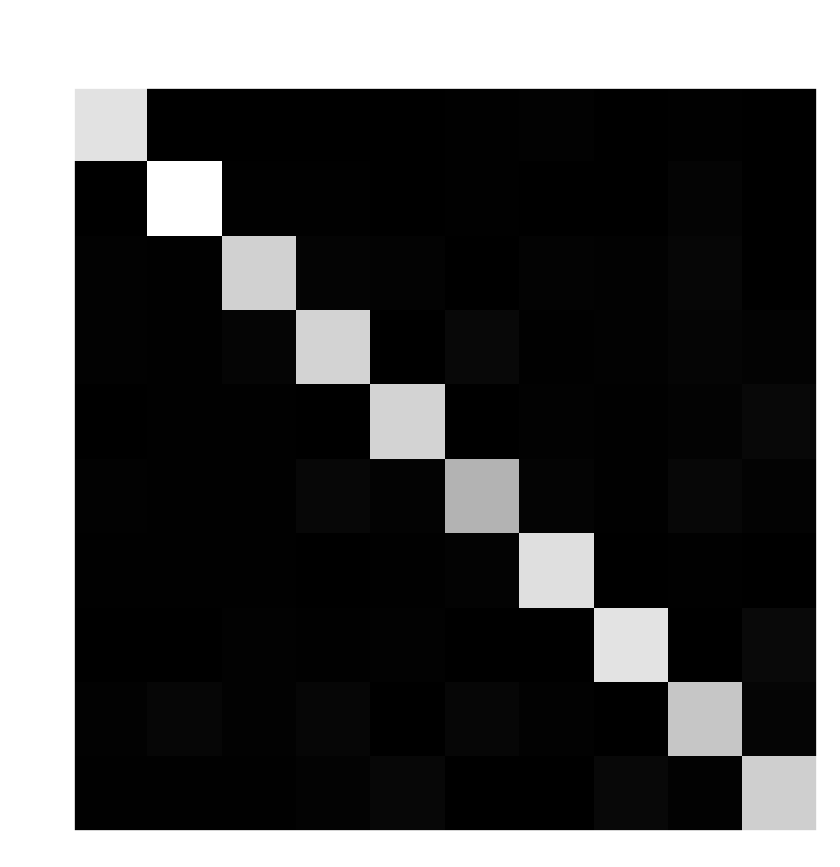

In [161]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [162]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

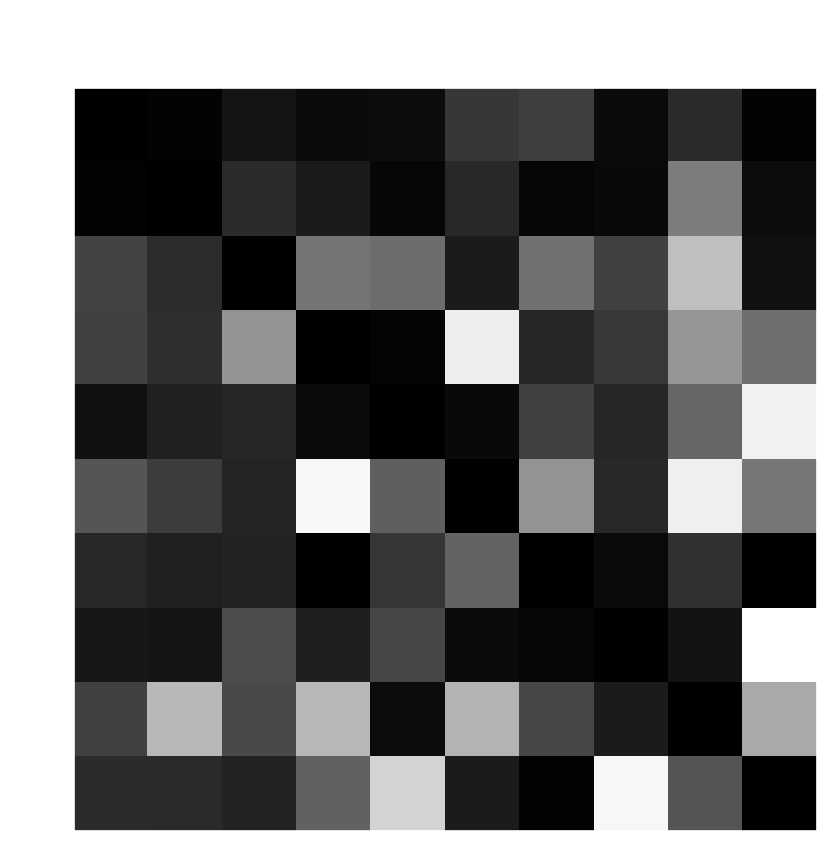

In [163]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**Multilabel Classification**


In [30]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(n_jobs=4)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=4, n_neighbors=5, p=2,
                     weights='uniform')

In [31]:
# This code creates a y_multilabel array containing two target labels for each digit
# image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
# indicates whether or not it is odd. The next lines create a KNeighborsClassifier
# instance (which supports multilabel classification, but not all classifiers do) and we
# train it using the multiple targets array. Now you can make a prediction, and notice
# that it outputs two labels:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# And it gets it right! The digit 5 is indeed not large (False) and odd (True)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)


In [ ]:
f1_score(y_train, y_train_knn_pred, average="macro")

In [ ]:
# to give each label a weight equal to its support (i.e., the number of instances with that
# target label). To do this, simply set average="weighted" in the preceding code

**Multioutput Classification**

In [ ]:
# let’s build a system that removes noise from images. It will take as
# input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐
# sented as an array of pixel intensities, just like the MNIST images. Notice that the
# classifier’s output is multilabel (one label per pixel) and each label can have multiple
# values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
# classification system.

In [20]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

### KNN classifier


In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

## Exercise solutions
1. An MNIST Classifier With Over 97% Accuracy